In [191]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [192]:
def generate_power_spectra_data(savepath, system_filepaths):
    '''
    Creates mulitple .csv files with power spectra data corresponding to h, k, p, and q vector quantities 
    of each planet in each system.

    Params:
    - savepath: The path to the .csv file to save the data into.
    - system_filepaths: A list of filepaths that link to the .csv data files where the data is taken from.
    '''
    
    # Validates the input.
    if type(system_filepaths) != list:
        raise Exception('Please input the system filepaths as a list. The input is not a list.')

    try:
        # Defines the csv file object.
        csv_file = open(savepath, 'w', encoding = 'utf-8')

        # Initializes the header variable.
        header = 'Time'

        # Generates the header: Time,Planet 1 h,Planet 1 k,Planet 1 p,Planet 2 h...
        for planet_num in range(1, 10):
            planet_label = 'Planet {n}'.format(n = planet_num)
            header += ',' + planet_label + ' h,' + planet_label + ' k,' + planet_label + ' p,' + planet_label + ' q'

        # Ends the header line.
        header += '\n'

        # Writes the header to the .csv file.
        csv_file.write(header)

        # Loops through each system filepath in the filepaths list.
        for system_filepath in system_filepaths:
            # Reads in the data for the current system as a pandas dataframe.
            data = pd.read_csv(system_filepath)

            # Gets the time series.
            time = data['Time']

            # Captures the last timestep of the integration.
            endtime = time.iloc[-1].astype(float)

            # Skips the system if it failed to integrate the full 1 Myr interval.
            if endtime < 1e6:
                continue

            # Gets the relevant columns for all four relevant orbital elements.
            inclination_columns = sorted([column for column in data.columns if 'inclination' in column])
            eccentricity_columns = sorted([column for column in data.columns if 'ecc' in column])
            omega_columns = sorted([column for column in data.columns if 'omega' in column])
            Omega_columns = sorted([column for column in data.columns if 'Omega' in column])

            # Ensures that the arrays are of identical size.
            assert len(inclination_columns) == len(eccentricity_columns) == len(omega_columns) == len(Omega_columns)

            # Calculates the multiplicity of the system from the length of the inclination columns.
            multiplicity = len(inclination_columns)

            # Initializes a set of four vector lists of dimension (multiplicity, 1e6).
            h_vectors = np.empty((multiplicity, 10000))
            k_vectors = np.empty((multiplicity, 10000))
            p_vectors = np.empty((multiplicity, 10000))
            q_vectors = np.empty((multiplicity, 10000))

            # Loops through all possible number of planets in a system (1-9 Planets).
            for planet_num in range(multiplicity):
                # Sets the column label.
                inclination_label = inclination_columns[planet_num]
                eccentricity_label = eccentricity_columns[planet_num]
                omega_label = omega_columns[planet_num]
                Omega_label = Omega_columns[planet_num]

                # Gathers the four relevant orbital element values, casting from string to float values.
                inclinations = data[inclination_label].astype(float)
                eccentricities = data[eccentricity_label].astype(float)
                omegas = data[omega_label].astype(float)
                Omegas = data[Omega_label].astype(float)

                # Calculates the vectors using the numpy library.
                h_vectors[planet_num] = eccentricities * np.sin(omegas + Omegas)
                k_vectors[planet_num] = eccentricities * np.cos(omegas + Omegas)
                p_vectors[planet_num] = np.tan(inclinations / 2.0) * np.sin(Omegas)
                q_vectors[planet_num] = np.tan(inclinations / 2.0) * np.cos(Omegas)

                # Guards against index errors.
                assert len(h_vectors[planet_num]) == len(k_vectors[planet_num]) == len(p_vectors[planet_num]) == len(q_vectors[planet_num])

            h_vectors = h_vectors.T
            k_vectors = k_vectors.T
            p_vectors = p_vectors.T
            q_vectors = q_vectors.T

            # Loops through each planet in the given system.
            for row_num in range(len(h_vectors)):
                # Initializes the row output.
                row = str()

                # Loops through each column of the given row.
                for col_num in range(len(h_vectors[row_num])):
                    h_str = h_vectors[row_num][col_num].astype(str)
                    k_str = k_vectors[row_num][col_num].astype(str)
                    p_str = p_vectors[row_num][col_num].astype(str)
                    q_str = q_vectors[row_num][col_num].astype(str)

                    if col_num == 0:
                        # Gets the value of each vector at the given row index, casting to strings.
                        time_str = time[row_num].astype(str)

                        row += time_str + ','
                    else:
                        row += ','

                    # Generates the output string for the current row.
                    row += ','.join([h_str, k_str, p_str, q_str])

                row += '\n'

                # Writes the row to the .csv file.
                csv_file.write(row)

    # Handles exceptions.
    except FileNotFoundError as e:
        print(e)



In [193]:
system_filepaths = [os.path.join(os.pardir, os.pardir, 'data', 'sysSim_4.csv')]
savepath = os.path.join(os.pardir, os.pardir, 'results', 'inclinations', 'power_spectra_sysSim_4.csv')

generate_power_spectra_data(savepath, system_filepaths)

In [194]:
data = pd.read_csv(os.path.join(os.pardir, os.pardir, 'results', 'inclinations', 'power_spectra_sysSim_4.csv'))

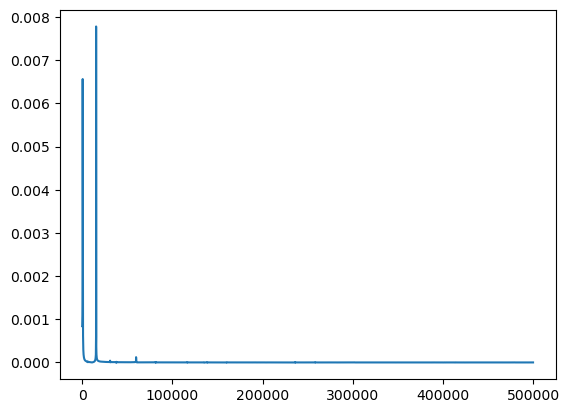

In [224]:
(x, y) = (data['Time'], data['Planet 2 p'])

cutoff = 5000

fft = np.abs(np.fft.fft(y))[:cutoff]

plt.plot(x[:cutoff], (fft/10000))